In [20]:
import networkx as nx
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from karateclub import Node2Vec
from src.helper import draw_spring, load_graph_from_json
np.random.seed(123)

ModuleNotFoundError: No module named 'karateclub'

# 4 Community Detection

The detection of communities can bring structure in the network, making the results easier to interpret. In a court decisions citation network, for instance, one rather inspects 35 communities than 2,500 nodes. Ideally, the communities are substantively meaningful, meaning that the court decisions within a community have properties in common that they do not, or to a lesser extent, share with court decisions outside of that community. For instance, court decisions in a specific community in a given network might share that they are about causality, or about traffic accidents, whereas other communities might be about other legal or factual topics. This way, community detection can reveal groups of decisions that concern certain topics, facts, or are otherwise related based on citation patterns.

Community detection methods exist that automatically assign nodes to communities. Below, we give insight into how community detection works. 

## 4.1  Machine Learning Methods - KMeans Clustering on Embeddings

One way to find communities is to use machine learning methods on an "embedding" of the network. From a machine learning perspective, the task of finding communities is one of "unsupervised learning", where the algorithm is expected to find patterns in unlabelled data. The network does not come with ready-made community labels, and unsupervised learning is used to generate them. 

In order to use machine learning techniques, however, a network embedding is needed. A network in itself does not have the structure that makes it possible to run a machine learning algorithm on it. Even more, networks may have too many dimensions for an algorithm to run succesfully on them. Consequently, one needs to find a mathematical representation of the network that makes it possible to achieve the desired results.

The most common unsupervised learning algorithm is KMeans clustering. In this section, this will be the only algorithm used, and it will be introduced in subsection A. However, it should be possible to use virtually any unsupervised learning algorithims on the appropiate network embedding.

Regarding network embeddings, this section will consider the adjacency matrix, the laplacian matrix, the eigenvectors associated with the largest eigenvalue and the embedding produced by node2vec. These are all called embeddings here insfoar they constitute a matheamtical representation of the network. Not all of them are equally good. As we will see, some of these representations lead to unsatisfactory results. But the concept of embeddings is best understood in the progression from the adjacency matrix to more complex representations.

The recurring example will be the classification of the two factions of Zachary's 'karate club' network. The 'karate club' network was recorded by a classic study in network analysis. In 1977 W.W. Zachary published "An Information Model for Conflict and Fission in Small Groups" in the Journal of Anthropological Research. The study is based on observation of a university karate club that would split due to disagreements between the club president and the instructor, leading to the creation of a new club. Network analysis of the friendship relations within the group would serve to predict with more than 97% accuracy who would side with join the group of the President and who would join the group of the instructor (Zachary used Maximum Flow Cut Labelling).

In the networkx version of the dataset, the president is node 0, and the karate instructor node 33. Lets plot the karate club graph here to remember its structure.

<img src="images/shared/karate_generic.png"/>


### A. KMeans clustering

Kmeans cluster communities are identified by assining nodes to a set of hipothesized clusters. In K-means cluster the K is the hypothesized number of clusters. So if one thinks there are 2 clusters, then k=2, if one things there are 3 clusters, k=3 and so on.

The goal of the K-means clustering technique is to partition space so as to minimize the sum of sqaured residuals from the hipothesized mean within the assumed set of clusters.

SSR is defined as:

$$ SSR =  \sum (x - \mu) $$

Kmeans records the SSR for every cluster, and tries to mimize the value of SSR over all the hypothesized $k$ clusters

$$ argmin\big(\sum_i^k \sum (x - \mu)\big) $$

Note the precedence of the summartion operators $\Sigma$. The first summation operator does the SSR within each cluster. The second summation operator sums the results for each of the clusters.

(We leave out of consideration whether the SSR should be normalized or not)

We speak over hypothesized clusters and means because the way that Kmeans works (in its most basic form) is by:

1) First hypothesizing a mean for each of the cluster randomly.
2) Assigning each data point to the mean that is closest to it
3) Measuring the SSR score
4) Calculating new means on the basis of the existing clusters.
5) Repeat from point 2...
6) Until data points no longer change clusters (convergence), a specified number of iteration or meeting a tolerance threshold

Below we can see KMeans in action in a traditional dataset. The iris dataset records the petal lenght, petal width, sepal length and sepal width of 3 species of iris flowers. It can be seen that -for example- the size and with of the petals is highly correlated and is predictive of what species of flower we are looking at.

<Axes: xlabel='petal_length', ylabel='petal_width'>

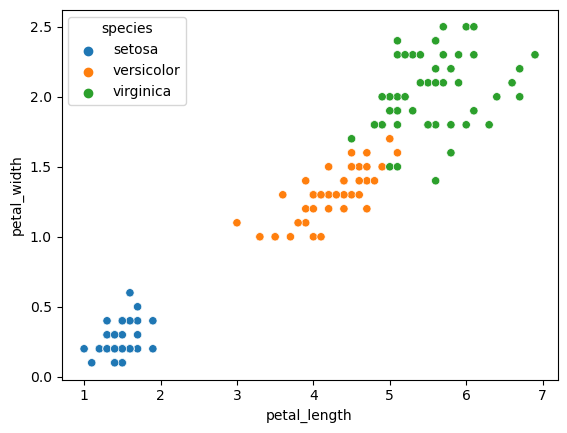

In [4]:
iris = sns.load_dataset("iris")
iris.head()
sns.scatterplot(data=iris, x="petal_length", y="petal_width", hue="species")

But lets imagine that we do not have the labels to begin with. KMeans can be used to divide the dataset into 3 parts. As we can see from the plot below, it reaches an almost perfect match to the actual taxonomic classification.

Here we will run the algorithm in verbose form to see how SSR decreases with each step. 

Initialization complete
Iteration 0, inertia 136.43.
Iteration 1, inertia 79.20444108199493.
Iteration 2, inertia 78.85144142614601.
Converged at iteration 2: strict convergence.


<Axes: xlabel='petal_length', ylabel='petal_width'>

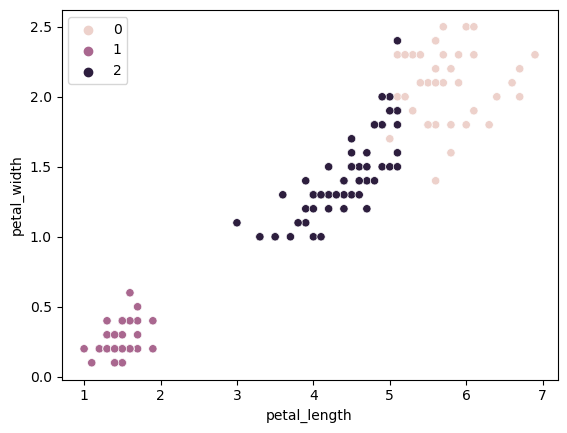

In [5]:
km = KMeans(n_clusters=3, verbose=True, n_init=1).fit(iris.drop("species", axis=1))
predictions = km.predict(iris.drop("species", axis=1))
sns.scatterplot(data=iris, x="petal_length", y="petal_width", hue=predictions)

### B. Clustering on the adjacency matrix and the laplacian matrix

Now lets try to get the two groups using KMeans clustering on the adjacency matrix and the laplacian matrix. 

This is a good time to recall a variety of matrices that help represent the information on a graph. First we have the degree matrix. This records on every degree of every node in the diagonal.

$$ D = \pmatrix{
2 & 0 & 0 & 0 \\ 
0 & 3 & 0 & 0 \\ 
0 & 0 & 3 & 0 \\ 
0 & 0 & 0 & 2 \\ 
} $$

The adjacency matrix, by contrast, records the edges between the nodes. So a 1 here means a link from a node to another and a 0 none (this was explained in more detail in section 3.3). 

$$ A = \pmatrix{
0 & 1 & 1 & 0 \\ 
1 & 0 & 1 & 1 \\ 
1 & 1 & 0 & 1 \\ 
0 & 1 & 1 & 0 \\ 
} $$

Using these two matrices we can find the Graph Laplacian matrix by simply subtracting the adjacency matrix from the degree matrix, so 

$$ L = D-A $$

Substraction of matrices is basic arithmetic, it just means elementwise substractions, so we do (for the first row:) 2-0, 0-1, 0-1, 0-0, and so forth until we get:

$$ L = \pmatrix{
2 & -1 & -1 & 0 \\ 
-1 & 3 & -1 & -1 \\ 
-1 & -1 & 3 & -1 \\ 
0 & -1 & -1 & 2 \\ 
} $$

Naturally the arithmetic involved in this will be practically impossible for humans on any matrix of reasonable size. Software can just give you the Laplacian matrix of a graph on command.

Using either the adjacecny matrix or the graph matrix does not succeed. The president (node 0) and the karate instructor (33) are put in different groups, but the students are not correctly classified in their respective clicques.

Arguably the reason this does not work is that the adjacency matrix and the laplacian matrix are poor representations of the graph for machine learning. While the network can be reconstructed from these matrices, from a machine learning perspective all that these representations record is the neighbors that are one jump away from each other, and degree infomration if it is a laplacian matrix. 

/home/gmas/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


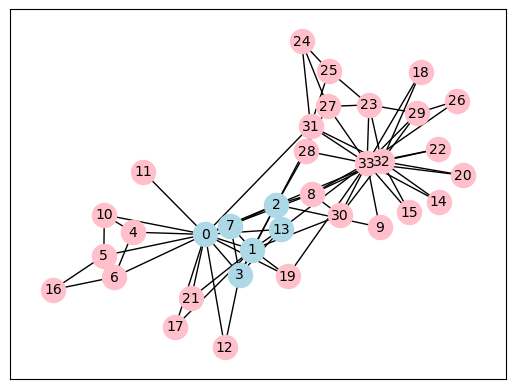

In [5]:
g_karate = nx.karate_club_graph()
M = nx.adjacency_matrix(g_karate).todense()

km = KMeans(2)
res = km.fit_predict(M)

reszero = np.where(res==0)[0].tolist()
resone = np.where(res==1)[0].tolist()

pos = nx.spring_layout(g_karate, seed=123)
nx.draw_networkx_nodes(g_karate, pos = pos, nodelist=reszero, node_color="lightblue")
nx.draw_networkx_nodes(g_karate, pos = pos, nodelist=resone, node_color="pink")
nx.draw_networkx_edges(g_karate, pos = pos)
nx.draw_networkx_labels(g_karate, pos = pos, font_size=10);

The results are worse if we use the laplacian matrix.

/home/gmas/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


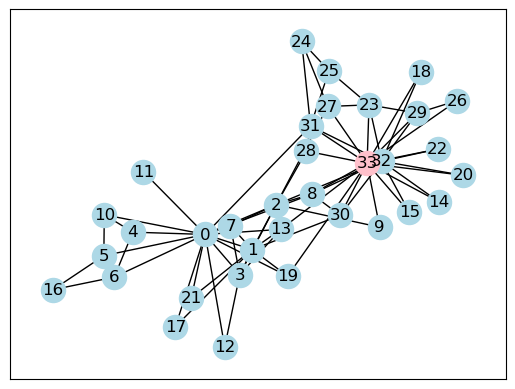

In [6]:
M = nx.laplacian_matrix(g_karate).todense()


km = KMeans(2)
res = km.fit_predict(M)

reszero = np.where(res==0)[0].tolist()
resone = np.where(res==1)[0].tolist()

pos = nx.spring_layout(g_karate, seed=123)
nx.draw_networkx_nodes(g_karate, pos = pos, nodelist=reszero, node_color="lightblue")
nx.draw_networkx_nodes(g_karate, pos = pos, nodelist=resone, node_color="pink")
nx.draw_networkx_edges(g_karate, pos = pos)
nx.draw_networkx_labels(g_karate, pos = pos);

### C. Spectral clustering


The problem with the above attempt is that the adjacency matrix or laplacian is a not a good network embedding for the purposes of clustering. It fails to represent "what is going on" inside the network. 

A better approach would be spectral clustering. Here isntead of using either one of the aforementioned matrixes, we apply clustering to certain mathematic properties that arise from the laplacian matrix, through so-called spectral decomposition. 

First we need the laplacian matrix of the karate club graph.

In [7]:
laplacian_karate = nx.laplacian_matrix(g_karate)

The next step is to find the eigenvector associated with the n smallest non-zero eigenvalues. The n depends on how many clusters you want. If you want two clusters, you need to look for the smallest eigenvector. If you want three clusters, you select the two smallest, and so on.

Let us print a list of eigenvalues (obtained with Numpy). Note that there are 34 eigenvalues, one for each node in the Karate club network example.

In [8]:
# this get us the values and the vectors
vals, vecs = np.linalg.eig(laplacian_karate.todense())
# here we extract the values
vals

array([5.20653410e+01, 4.59907681e+01, 4.18328632e+01, 3.79927558e+01,
       2.96883840e+01, 2.55555039e+01, 2.27849630e+01, 2.13586504e+01,
       1.93238240e+01, 1.70337951e+01, 1.48885752e+01, 1.43813508e+01,
       1.20754027e+01, 1.18744202e+01, 7.46525661e-15, 1.02218147e+01,
       1.00106981e+01, 9.18096651e+00, 1.18710730e+00, 6.97788032e+00,
       6.44605541e+00, 5.59481244e+00, 2.39431926e+00, 5.16855490e+00,
       4.97817925e+00, 4.69727550e+00, 4.54469763e+00, 4.16160574e+00,
       3.70606484e+00, 3.80094429e+00, 2.93182048e+00, 2.96830180e+00,
       3.12126310e+00, 3.06104079e+00])

Lets sort the values to make it easier to spot the second smallest eigenvalue.

In [9]:
np.sort(vals)

array([7.46525661e-15, 1.18710730e+00, 2.39431926e+00, 2.93182048e+00,
       2.96830180e+00, 3.06104079e+00, 3.12126310e+00, 3.70606484e+00,
       3.80094429e+00, 4.16160574e+00, 4.54469763e+00, 4.69727550e+00,
       4.97817925e+00, 5.16855490e+00, 5.59481244e+00, 6.44605541e+00,
       6.97788032e+00, 9.18096651e+00, 1.00106981e+01, 1.02218147e+01,
       1.18744202e+01, 1.20754027e+01, 1.43813508e+01, 1.48885752e+01,
       1.70337951e+01, 1.93238240e+01, 2.13586504e+01, 2.27849630e+01,
       2.55555039e+01, 2.96883840e+01, 3.79927558e+01, 4.18328632e+01,
       4.59907681e+01, 5.20653410e+01])

Note that numpy will often give you very small numbers which are equivalent to zero. Here the first number is practically a zero. We can see this if we round the numbers to, say, 5 decimal places.

In [10]:
np.sort(np.round(vals,5))

array([ 0.     ,  1.18711,  2.39432,  2.93182,  2.9683 ,  3.06104,
        3.12126,  3.70606,  3.80094,  4.16161,  4.5447 ,  4.69728,
        4.97818,  5.16855,  5.59481,  6.44606,  6.97788,  9.18097,
       10.0107 , 10.22181, 11.87442, 12.0754 , 14.38135, 14.88858,
       17.0338 , 19.32382, 21.35865, 22.78496, 25.5555 , 29.68838,
       37.99276, 41.83286, 45.99077, 52.06534])

Now we can see that the smallest non-zero eigenvalue is 1.18710730e+00. To avoid human errors with counting, we can use ````np.where```` to find its position.

It tells us that it is the position 18 in the array.

In [11]:
# because python indexes start at 0, indexing at 1 will give us the second smallest value.
smallest_non_zero = np.sort(vals,)[1]
np.where(vals==smallest_non_zero)

(array([18]),)

Which we can confirm as true

In [12]:
vals[18]

1.1871073019962102

Now we need to get the eigenvector associated with the smallest non-zero eigenvalue, which is the eigenvector in position 18. Here we just need to index into the 18th column (counting from zero) of the eigenvector variable.

In [13]:
X = vecs[:,18]
X = np.asarray(X)
X

array([ 0.1233171 ,  0.0580066 ,  0.01368446,  0.07445083,  0.26733837,
        0.29881441,  0.29744558,  0.06406144, -0.0530052 , -0.12925543,
        0.28550172,  0.20406685,  0.12324309,  0.03493189, -0.17156602,
       -0.15520216,  0.37166422,  0.16804128, -0.21148231,  0.0625882 ,
       -0.18847412,  0.1289233 , -0.16858175, -0.14801794, -0.15762212,
       -0.14632034, -0.19249255, -0.12982346, -0.09449019, -0.16960883,
       -0.08368282, -0.1170647 , -0.13538405, -0.12400534])

Having this, we can cluster them using KMeans. In our case, we select two clusters because we know from the paper by Zachary that the group would split into two.

In order to run KMeans first we need to turn the array X into a two dimensional array (even if it will really be only one column), as sklearn expects this type of data.

> A one dimensional array does not specify if the array is a row or a column. A two dimensional array will specify if it is a row or a column, even if it has only one row or only one column. In this sense it is "two dimensional".

In [14]:
print(X.shape)
# the -1 here says "give me as many rows as necessary", the 1 says "and just one column"
X = X.reshape(-1,1)
print(X.shape)

(34,)
(34, 1)


Before running KMeans, if we inspect the vector visually we may see that it is possible to see two clusters, one of positive signed numbers and one of positive signed numbers.

In [15]:
np.sort(X, axis=0)

array([[-0.21148231],
       [-0.19249255],
       [-0.18847412],
       [-0.17156602],
       [-0.16960883],
       [-0.16858175],
       [-0.15762212],
       [-0.15520216],
       [-0.14801794],
       [-0.14632034],
       [-0.13538405],
       [-0.12982346],
       [-0.12925543],
       [-0.12400534],
       [-0.1170647 ],
       [-0.09449019],
       [-0.08368282],
       [-0.0530052 ],
       [ 0.01368446],
       [ 0.03493189],
       [ 0.0580066 ],
       [ 0.0625882 ],
       [ 0.06406144],
       [ 0.07445083],
       [ 0.12324309],
       [ 0.1233171 ],
       [ 0.1289233 ],
       [ 0.16804128],
       [ 0.20406685],
       [ 0.26733837],
       [ 0.28550172],
       [ 0.29744558],
       [ 0.29881441],
       [ 0.37166422]])

Or more visually...

<Axes: >

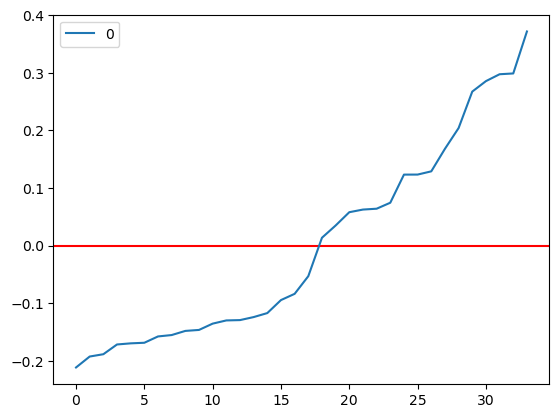

In [16]:
plt.axhline(0, color="red")
sns.lineplot(np.sort(X, axis=0))

Now we run KMeans with the requirement of finding two clusters

In [17]:
from sklearn.cluster import KMeans
km = KMeans(2)

# Kmeans will return an array, but networkx (in the next cell) will want a list. 
# Therefore we need to conver to a list, and get the indexes (the positions) in the list where our results lie

results = list(km.fit_predict(X))


nodes_cluster_1 = [x[0] for x in enumerate(results) if x[1]==0]
print("nodes for cluster 1", nodes_cluster_1,"\n")
nodes_cluster_2 = [x[0] for x in enumerate(results) if x[1]==1]
print("nodes for cluster 2", nodes_cluster_2,"\n")

nodes for cluster 1 [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21] 

nodes for cluster 2 [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33] 



/home/gmas/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


And here we can see the results of the clustering, which give you a very reasonalbe partition of the network.

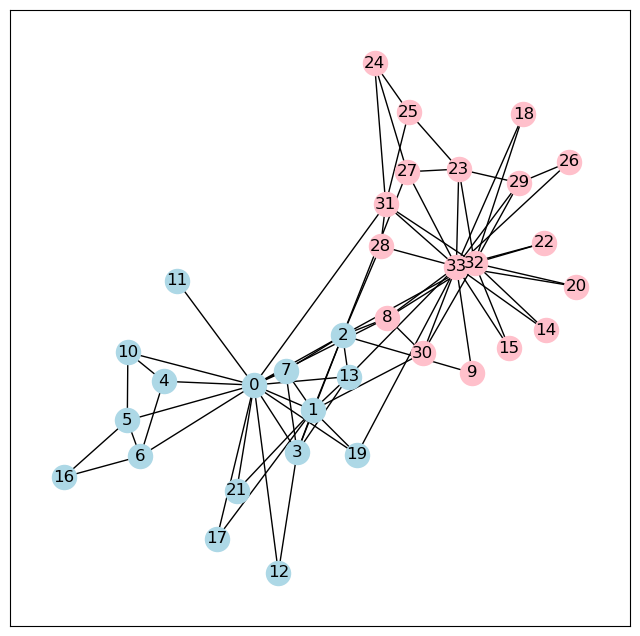

In [18]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_karate, seed =123)
nx.draw_networkx_nodes(g_karate, pos=pos, nodelist=list(nodes_cluster_1), node_color="lightblue")
nx.draw_networkx_nodes(g_karate, pos=pos, nodelist=list(nodes_cluster_2), node_color="pink")
nx.draw_networkx_labels(g_karate, pos=pos)
nx.draw_networkx_edges(g_karate, pos=pos)

### D. Node 2 Vec

A final, more modern approach to consider now is Node2Vec. This is an algorithm that produces graph embeddings. That is, it turns a graph into a mathematical representation that has some high degree of fidelity to what is going on in the network. Explaining Node2Vec is beyond the scope of this work. However we can instantiate it and see it in action. Here we will represent the karate club graph in 3 dimensions (the default is 128 dimensions, so this is a highly watered down version). In practice, node2vec will simplify the graph by giving each of the 34 nodes 3 values. This can be seen in the array below:

In [19]:
n2v = Node2Vec(dimensions=3)
n2v.fit(g_karate)
X = n2v.get_embedding()
X

NameError: name 'Node2Vec' is not defined

Now we run the Kmeans algorithm on the embedding.

In [21]:
km = KMeans(n_clusters=2)
results = km.fit_predict(X)
nodes_cluster_1 = [x[0] for x in enumerate(results) if x[1]==0]
print("nodes for cluster 1", nodes_cluster_1,"\n")
nodes_cluster_2 = [x[0] for x in enumerate(results) if x[1]==1]
print("nodes for cluster 2", nodes_cluster_2,"\n")

nodes for cluster 1 [2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33] 

nodes for cluster 2 [0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21] 



/home/gmas/miniconda3/envs/Gus_1/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


And the result is a very reasonable approximation to the split between the two groups.

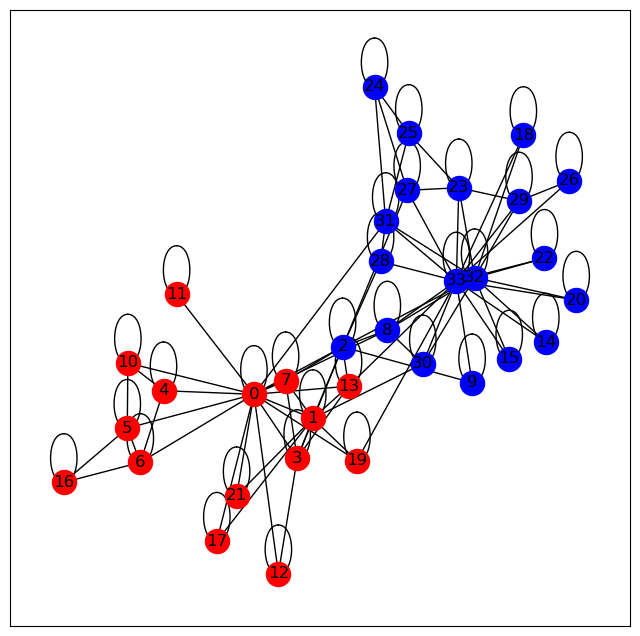

In [22]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_karate, seed =123)
nx.draw_networkx_nodes(g_karate, pos=pos, nodelist=list(nodes_cluster_1), node_color="blue")
nx.draw_networkx_nodes(g_karate, pos=pos, nodelist=list(nodes_cluster_2), node_color="red")
nx.draw_networkx_labels(g_karate, pos=pos)
nx.draw_networkx_edges(g_karate, pos=pos)

## 4.2 Network Algorithms - Louvain Communities

In opposition to machine learning methods we can find network algorithms. These do not transform the graph into an embedding, to then run traditional machine learning algorithms (like KMeans clustering). Rather they work with the existing graph and its properties to find clusters. 

In relation to network algorithms we will consider only the Louvain method for community detection. This is an algorithm that finds communities by using the concept of modularity gain. 

In order to fully introduce this method, we first have to understand the concept of modularity.

### A. Modularity

Modularity in essence does two things:
1. It compares the edges of nodes in a certain community to the edges the nodes have to nodes outside of the community. Court decisions on contract law are more likely to cite one another (edges within the community) than to cite court decisions on human rights (edges outside of the community). The edges within the community can be compared to the edges outside of the community. The higher the number of edges within the community relative to the edges with nodes outside of the community, the higher the modularity.
2. It takes into consideration the number of edges in the network. The higher the number of edges in the network, the less important the difference becomes between the edges within the community and the edges to nodes outside of the community. This prevents small yet dense communities obtaining the highest modularity score and makes it more likely that larger denser communities (with more edges) will receive a high modularity score.

Both considerations are reflected in the formula for modularity, For ease of presentation, we will only consider modularity for undirected networks.

The formula for modularity can be presented in a variety of ways and there are advantages to each form or presentation. Here are two formulas:

$$ Q = \frac{1}{2m}\sum_{c=1}^{n} \left[ \Sigma A_c - \gamma\frac{\Sigma D_c^2}{2m} \right] $$


$$ Q = \sum_{c=1}^{n} \left[ \frac{\Sigma A_c}{2m} - \gamma\left( \frac{\Sigma D_c}{2m} \right) ^2 \right] $$

(These formulas have been adapted from the documentation to make the notation easier to follow, especially for an attempt to put them in practice by hand.)

For our discussion we will focus on the second formula, because it most clearly shows a difference between two ratios. The representation we choose here provides the most insight into what modularity does. 

* $ \Sigma A_c $ is the sum of the adjacency matrix of the community only (no edges to nodes outside of the community) .

* $ m $ is the total number of edges of the network.

* $\Sigma D_c$ is the degree of the nodes of the community, taking into consideration their edges to nodes outside of the community.

* $\gamma$ is a dampening parameter, that for our purposes can be ignored if set to 1. Making this number smaller will make it easier to find communities, and making it larger makes communities harder to find. (!!CHECK!!)

We observe a difference between fractions. That is to say, a difference between proportions.

* $ \frac{\Sigma A_c}{2m} $ represents the proportion of purely intra-community edges for a given community to the total number of edges. The division by 2 considers the fact that the adjacency matrix will count two for every edge.

* $ \left( \frac{\Sigma D_c}{2m} \right) ^2 $ represents the proportion of the edges that a community has to nodes within and outside of itself to the total number of edges in the network.

The logic of this is that if the left hand side of the difference is greater than the right hand side of the difference one will get a positive number. And the larger the difference, the tighter a community is, the larger the number. 

* The $ \Sigma $ is a summation notation that states that the difference between fractions will be repeated for every hypothesized community and added up. The higher the ultimate summation, the better the community partition is.

We can operationalize the formula "by hand" on the graph of Florentine families hypothesizing that the families Castellani, Peruzzi and Strozzi form a community vis-a-vis the rest of the other families. A quick look at the graphs suggest that this is a reasonable grouping.

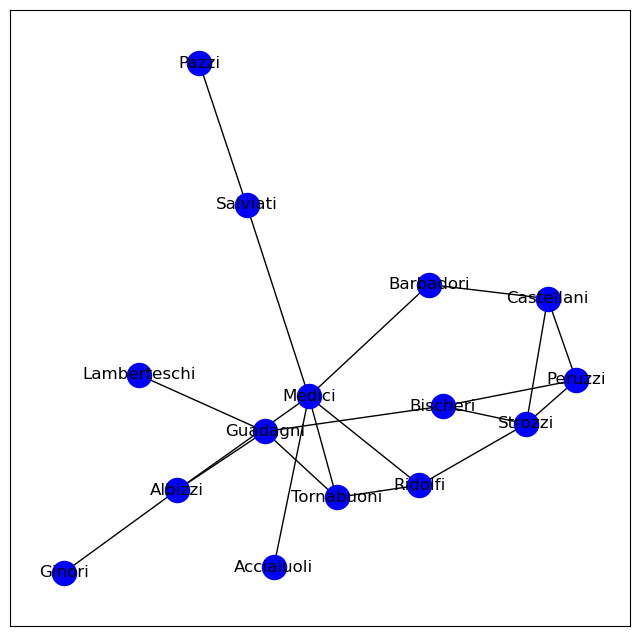

In [23]:
g_florentine = nx.florentine_families_graph()
draw_spring(g_florentine)

First let us save two lists with the names of the nodes that we want to use as hypothesized communities. Castellani, Peruzzi and Strozzi in one list, the rest on the other.

In [24]:
fl_CPS = ['Castellani','Peruzzi','Strozzi']
fl_other= ['Acciaiuoli', 'Medici', 'Barbadori', 'Ridolfi', 'Tornabuoni', 'Albizzi', 'Salviati', 'Pazzi', 'Bischeri', 'Guadagni', 'Ginori', 'Lamberteschi']

Since m is just the number of edges we can obtain the number in this manner.

In [25]:
m = len(g_florentine.edges)
m

20

For $\Sigma A_c $ we need to get the adjacency matrix of just the nodes within the community. This means we need to sever the connection of the community with other nodes. We can get this with the subgraph function.

In [26]:
sub_fl_CPS = g_florentine.subgraph(fl_CPS)
sub_fl_other = g_florentine.subgraph(fl_other)

Now we can get the adjacency matrix of the subgraphs like this...

In [27]:
nx.adjacency_matrix(sub_fl_CPS).todense()

array([[0, 1, 1],
       [1, 0, 1],
       [1, 1, 0]])

Numpy can sum all the values of such matrices with a call to np.sum.

In [28]:
SA_cps = np.sum(nx.adjacency_matrix(sub_fl_CPS).todense())
SA_other = np.sum(nx.adjacency_matrix(sub_fl_other).todense())
print(f"the value of SigmaA_c for the CPS community is {SA_cps} and for the other is {SA_other}")

the value of SigmaA_c for the CPS community is 6 and for the other is 26


This gets us all we need for the left hand side of the difference.

Now we move to work on the right side of the difference. The value of $ \Sigma D_c $ is the sum of the degree of the nodes that interest us, but not with their values cut off from the network -that is, not as subgraphs- but in their full values connected to the Florentine families network. 

In terms of code it can be slightly tricky to unpack these values. Below we use a np.sum over a list comprehension that produces the degree scores of only the nodes we need.

In [29]:
SD_cps = np.sum([x[1] for x in list(nx.degree(g_florentine, fl_CPS))])

SD_other = np.sum([x[1] for x in list(nx.degree(g_florentine, fl_other))])

print(f"the value of SigmaD_c for the CPS community is {SD_cps} and for the other is {SD_other}")

the value of SigmaD_c for the CPS community is 10 and for the other is 30


Now we are ready to fill in the blanks. Remember the formula is:

$$ Q = \sum_{c=1}^{n} \left[ \frac{\Sigma A_c}{2m} - \gamma\left( \frac{\Sigma D_c}{2m} \right) ^2 \right] $$

So for the first community we have

$$ CPS =\left[ \frac{6}{40} - \gamma\left( \frac{10}{40} \right) ^2 \right] = 0.875 $$

In [30]:
CPS_result = (SA_cps/(2*m)) - ((SD_cps/(2*m))**2)
CPS_result

0.0875

And for the second 

$$ other = \left[ \frac{26}{40} - \gamma\left( \frac{30}{40} \right) ^2 \right] = 0.875 $$

In [31]:
other_result = (SA_other/(2*m)) - ((SD_other/(2*m))**2)
other_result

0.08750000000000002

And adding them together we get 0.175

In [32]:
CPS_result + other_result

0.17500000000000002

 Which is the same as the official result.

Thus the following partition has the positive modularity score of 0.175.

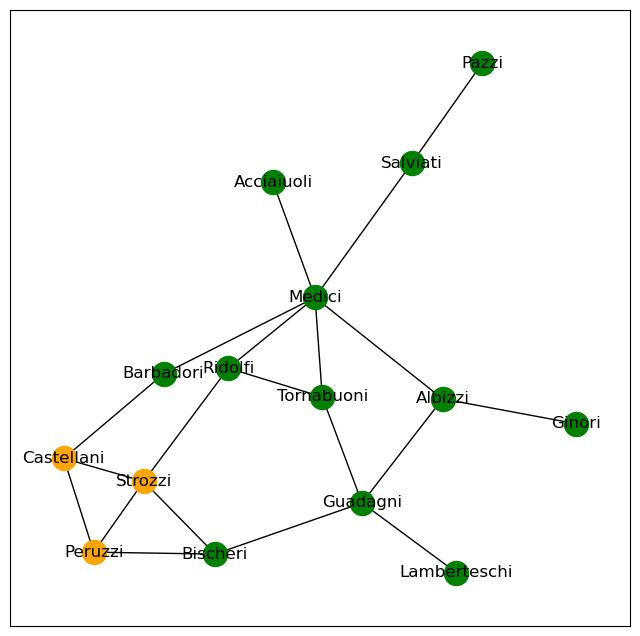

In [33]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_florentine)
nx.draw_networkx_nodes(g_florentine, pos, nodelist=fl_CPS, node_color='orange')
nx.draw_networkx_nodes(g_florentine, pos, nodelist=fl_other, node_color='green')
nx.draw_networkx_edges(g_florentine, pos=pos)
nx.draw_networkx_labels(g_florentine, pos=pos);

### B. Louvain Communities

What Louvain community detection does, is to try to find the distribution of communities that will give the highest modularity score, using a sort of cumulative random search.

1. It will asume every node is a community and score the modularity.
2. It will assign every node to a community with one of its neighbors and score the modularity of the result.
3. It will keep the assignment that gives the highest modularity score.
4. The resulting communities will be treated as nodes.
5. Step 1 is repeated.

This process keeps going until there is no more modularity gain.

We can quickly try to run the Louvain communities algorithm to find the best partition of the Florentine families network that we used earlier to discuss modularity.
It turns out the best split is in four communities. Compared to our intuitive results presented above, we can see that Castellani, Peruzzi and Strozzi did deserve to go together, but that Bischeri should have been also part their team.

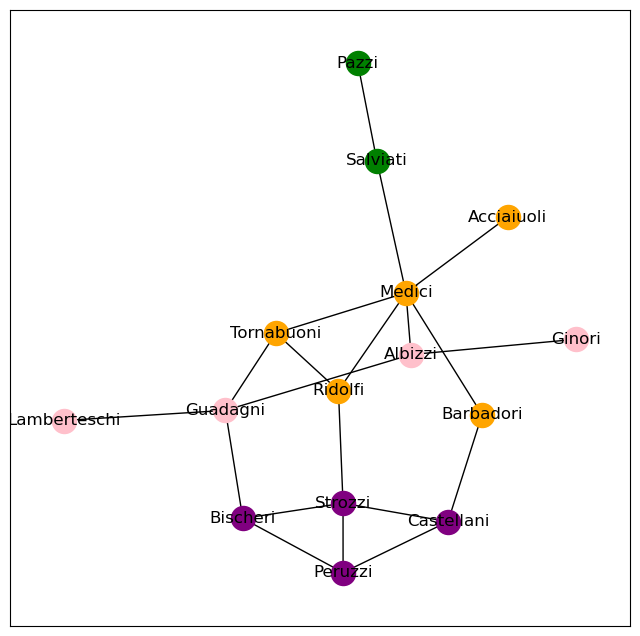

In [34]:
plt.figure(figsize=(8,8))
result = nx.algorithms.community.louvain_communities(g_florentine)
pos = nx.spring_layout(g_florentine)
nx.draw_networkx_nodes(g_florentine, pos, nodelist=result[0], node_color='orange')
nx.draw_networkx_nodes(g_florentine, pos, nodelist=result[1], node_color='green')
nx.draw_networkx_nodes(g_florentine, pos, nodelist=result[2], node_color='purple')
nx.draw_networkx_nodes(g_florentine, pos, nodelist=result[3], node_color='pink')
nx.draw_networkx_edges(g_florentine, pos=pos)
nx.draw_networkx_labels(g_florentine, pos=pos);

Now let us calculate the modularity score for the Louvain-detected communities. We can see that at 0.3975 it is quite a bit higher than our intuitive partition.

In [35]:
nx.algorithms.community.modularity(g_florentine, result)

0.39749999999999996

We now try to approximate this by hand. Let us see how far we can get. We will use a smaller graph, the kite, to make our life easier. There are key differences between what we are doing and the actual Louvain Communities algorithm. However, this will be enough for us to get an idea of what is going on.

The question is how to best partition the kite in terms of modularity.

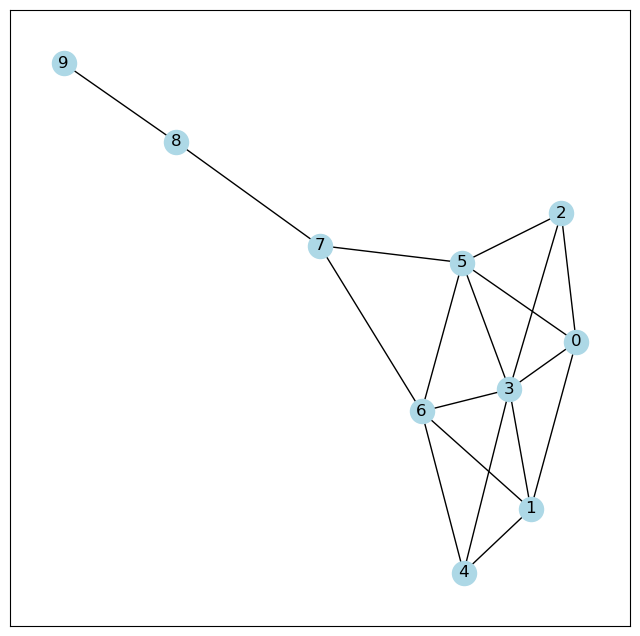

In [36]:
g_kite = nx.krackhardt_kite_graph()
draw_spring(g_kite, node_color="lightblue")

Doing a pseudo-Louvain process, We begin by assigning each node in the kite graph to its own community. Since this is a very bad partition, it makes sense that we get a negative modularity score.

In [37]:
nx.algorithms.community.modularity(g_kite, [[x] for x in range(0,10)])

-0.11574074074074076

Now we will assign each node, to one of its neighbors, and obtain the modularity score.

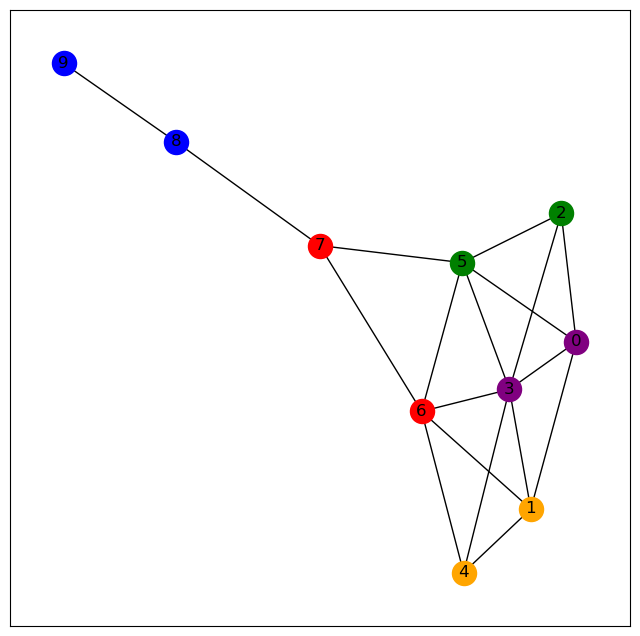

In [38]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_kite, seed=123)
nx.draw_networkx_nodes(g_kite, pos, nodelist=[9,8], node_color='blue')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[7,6], node_color='red')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[5,2], node_color='green')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[4,1], node_color='orange')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[3,0], node_color='purple')
nx.draw_networkx_edges(g_kite, pos=pos)
nx.draw_networkx_labels(g_kite, pos=pos);

In [39]:
nx.algorithms.community.modularity(g_kite, [[9,8], [7,6], [5,2],[4,1],[3,0]])

0.057098765432098755

Then we could keep assigning nodes and see an increase.

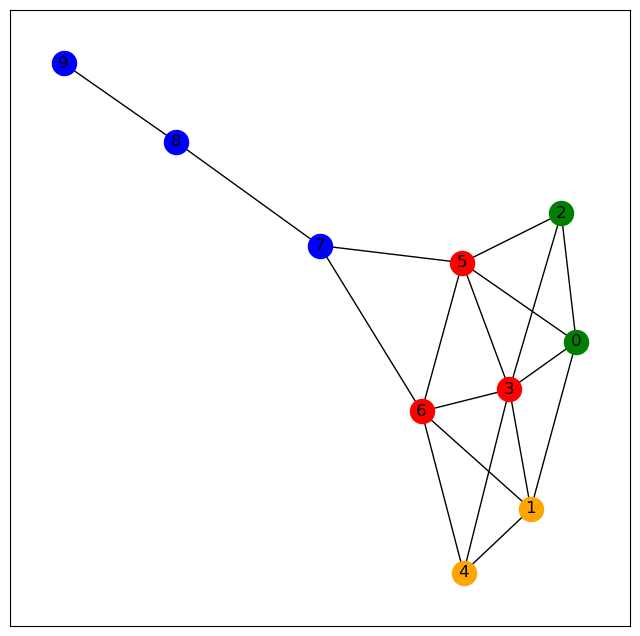

In [40]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_kite, seed=123)
nx.draw_networkx_nodes(g_kite, pos, nodelist=[9,8,7], node_color='blue')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[6,5,3], node_color='red')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[2,0], node_color='green')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[4,1], node_color='orange')
nx.draw_networkx_edges(g_kite, pos=pos)
nx.draw_networkx_labels(g_kite, pos=pos);

In [41]:
nx.algorithms.community.modularity(g_kite, [[9,8,7], [6,5,3], [2,0],[4,1]])

0.08796296296296295

But not every reassignment is going to be an increase. If we extend the first cluster, we will get a decrease in modularity.

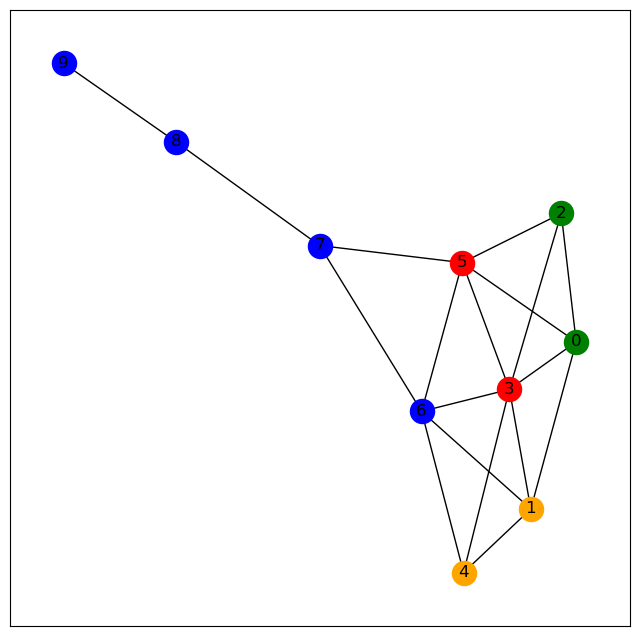

In [42]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_kite, seed=123)
nx.draw_networkx_nodes(g_kite, pos, nodelist=[9,8,7, 6], node_color='blue')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[5,3], node_color='red')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[2,0], node_color='green')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[4,1], node_color='orange')
nx.draw_networkx_edges(g_kite, pos=pos)
nx.draw_networkx_labels(g_kite, pos=pos);

In [43]:
nx.algorithms.community.modularity(g_kite, [[9,8,7, 6], [5,3], [2,0],[4,1]])

0.07098765432098764

Our pseudo-Louvain algorithm would therefore stop short of that last assignment. The real Louvain method would do this in an mechanical, incremental fashion until the communities with very good modularity scores are found. The algorithm has elements of randomness, so it is not guaranteed to achieve the best result, or the same result every time it is run.

A difference of note is that instead of incrementally linking up the nodes of the kite, what are the communities at the first level will be turned into nodes at the second level. (!!add photo from louvain to leuven article!!). 

What this means in practice, is that unlike what we are doing, the algorithm does not focus on modularity per se, but on modularity gain. That is, it focuses on the difference in modularity between one partitioning and another. It does not really look for the highest modularity value, but instead keeps going while it finds positive modularity gain, or until modularity gains are so small that they fall below a specified margin.

Happily, the formula for modularity gain is not so different from that of modularity

$$ \Delta Q = \left[ \frac{\Sigma A_c + K_{in}}{2m} - \frac{\Sigma D_c + K_{in}}{2m} \right] - \left[\frac{\Sigma A_c}{2m}-\frac{\Sigma D_c}{2m} - \frac{K_in}{2m}  \right]   $$

In fact it is the ratio of two modulary scores. One (the left brackets) is the score with the node K inserted into it and the the other (the right bracket) is the score with the node K removed from it. It is added on the left and removed on the right to represent the delta, or the difference in modularity, when one community gains a node and another one loses it.

With our pseudo-Louvain approach we did not did do the best possible combination, but with the real Louvain communities algorithm we can see what the better partition would be:

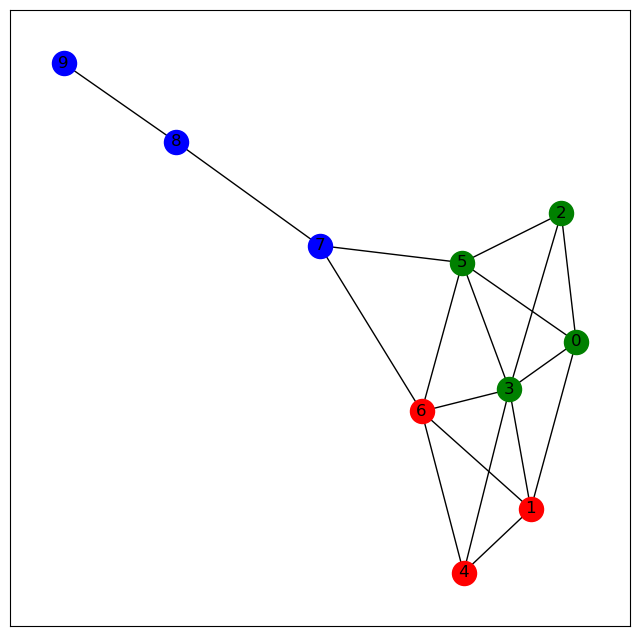

In [44]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_kite, seed=123)
result = nx.algorithms.community.louvain_communities(g_kite)
nx.draw_networkx_nodes(g_kite, pos, nodelist=result[0], node_color='red')
nx.draw_networkx_nodes(g_kite, pos, nodelist=result[1], node_color='green')
nx.draw_networkx_nodes(g_kite, pos, nodelist=result[2], node_color='blue')
nx.draw_networkx_edges(g_kite, pos=pos)
nx.draw_networkx_labels(g_kite, pos=pos);

We can do the same for the subgraph of the CJEU case law example. We first calculate the number of communities:

In [45]:
g_consprot2 = load_graph_from_json("data/g_consprot2.json")
communities = sorted(nx.algorithms.community.greedy_modularity_communities(g_consprot2), key=len, reverse=True)
print(f"The network has {len(communities)} communities.")

The network has 13 communities.


We subsequently plot assign each node to a community and visualize the communities in the network.

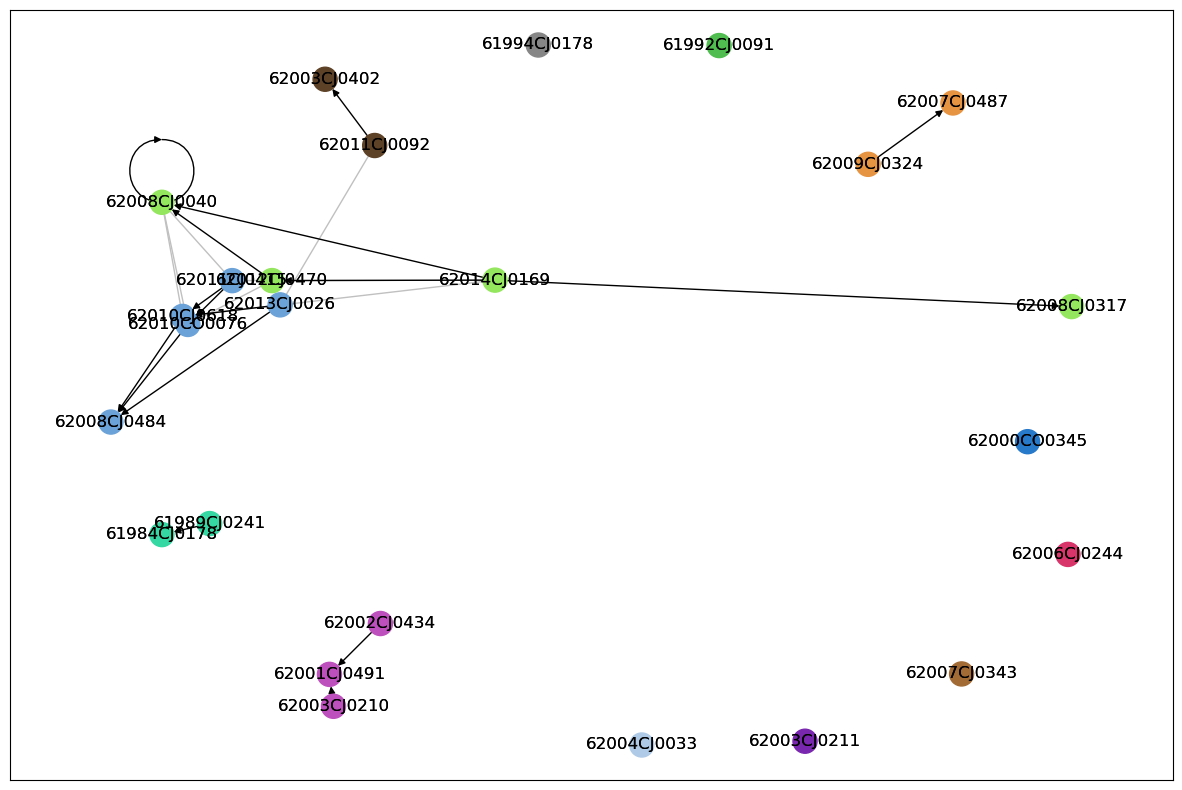

In [46]:

def set_node_community(G, communities):
    '''Add community to node attributes'''
    for c, v_c in enumerate(communities):
        for v in v_c:
            # Add 1 to save 0 for external edges
            G.nodes[v]['community'] = c + 1
def set_edge_community(G):
    '''Find internal edges and add their community to their attributes'''
    for v, w, in G.edges:
        if G.nodes[v]['community'] == G.nodes[w]['community']:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = G.nodes[v]['community']
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0
def get_color(i, r_off=1, g_off=1, b_off=1):
    '''Assign a color to a vertex.'''
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b)

# Set node and edge communities
set_node_community(g_consprot2, communities)
set_edge_community(g_consprot2)
node_color = [get_color(g_consprot2.nodes[v]['community']) for v in g_consprot2.nodes]
# Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in g_consprot2.edges if g_consprot2.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in g_consprot2.edges if g_consprot2.edges[v, w]['community'] > 0]
internal_color = ['black' for e in internal]

# Set node and edge communities
set_node_community(g_consprot2, communities)
set_edge_community(g_consprot2)
node_color = [get_color(g_consprot2.nodes[v]['community']) for v in g_consprot2.nodes]
# Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in g_consprot2.edges if g_consprot2.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in g_consprot2.edges if g_consprot2.edges[v, w]['community'] > 0]
internal_color = ['black' for e in internal]

g_consprot2_pos = nx.spring_layout(g_consprot2)
plt.rcParams.update({'figure.figsize': (15, 10)})
# Draw external edges
nx.draw_networkx(
    g_consprot2,
    pos=g_consprot2_pos,
    node_size=0,
    edgelist=external,
    edge_color="silver")
# Draw nodes and internal edges
nx.draw_networkx(
    g_consprot2,
    pos=g_consprot2_pos,
    node_color=node_color,
    edgelist=internal,
    edge_color=internal_color)
plt.show()

## 4.3 Centrality of communities

Once a community has been found, it is possible to submit that community to forms of analysis that were first applied to the whole graph. Naturally results will change when we only consider the smaller community.

In NetworkX this is done using the ````subgraph```` function, passing in the node list of the selected community. 

Here we will consider the community that centers around the President of the Karate Club which appears in red below.

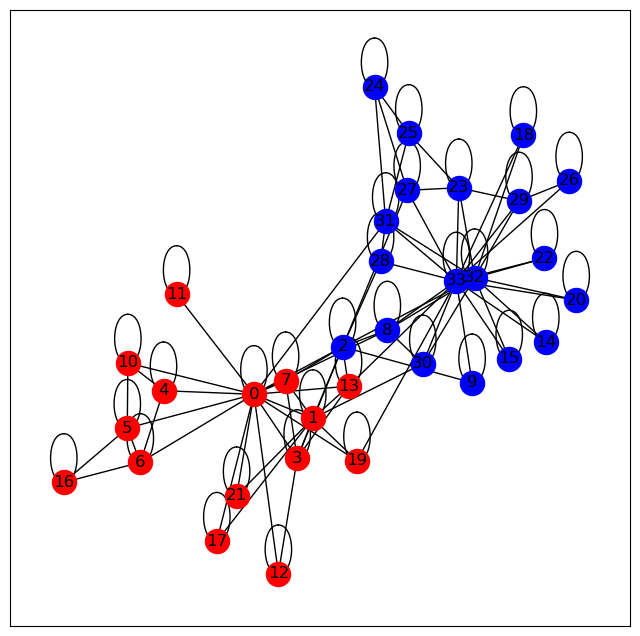

In [47]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_karate, seed =123)
nx.draw_networkx_nodes(g_karate, pos=pos, nodelist=list(nodes_cluster_1), node_color="blue")
nx.draw_networkx_nodes(g_karate, pos=pos, nodelist=list(nodes_cluster_2), node_color="red")
nx.draw_networkx_labels(g_karate, pos=pos)
nx.draw_networkx_edges(g_karate, pos=pos)

If we see the closeness centrality scores

In [48]:
karate_closeness = pd.DataFrame({"nodes":nx.closeness_centrality(g_karate).keys(), "centrality":nx.closeness_centrality(g_karate).values()})\
.sort_values("centrality", ascending=False)\
.head(10)
karate_closeness


,nodes,centrality
0,0,0.568966
2,2,0.559322
33,33,0.550000
31,31,0.540984
13,13,0.515625
32,32,0.515625
8,8,0.515625
19,19,0.500000
1,1,0.485294
3,3,0.464789


Here we can see that the top performers include the President at node 0, node 2, and the Karate instructor who is node 33.

However if we consider only the subgraph of the supporters of the President, the network metrics change, including the centrality ranking.

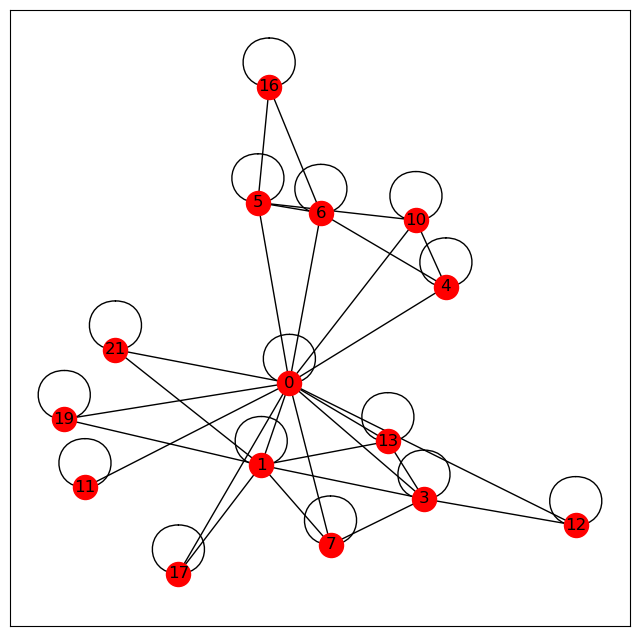

In [52]:
g_subkarate = nx.subgraph(g_karate, nodes_cluster_2)
draw_spring(g_subkarate, node_color="red")

In [53]:
pd.DataFrame({"nodes":nx.closeness_centrality(g_subkarate).keys(), "centrality":nx.closeness_centrality(g_subkarate).values()})\
.sort_values("centrality", ascending=False)\
.head(10)

,nodes,centrality
0,0,0.933333
1,1,0.636364
2,3,0.583333
4,5,0.583333
5,6,0.583333
3,4,0.560000
7,10,0.560000
6,7,0.538462
10,13,0.538462
9,12,0.518519


Node 2 is no longer as important now that his friends with the faction of the instructor are factored out. By contrast node 1 rises in prominence.

This analysis is only schematic, but it shows that identifying communities can be an important step for getting more finely grained network metrics.